#QUANTUM SUPPORT VECTOR MACHINE

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tqdm import tqdm
import time

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Capstone/MultiJetRun2010B.csv')
df.head()

Mounted at /content/drive


,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,148029,388,302318745,215.553,0.031977,136.7100,-109.893,-54.03420,-58.9032,142.1790,70.0254,41.12250,-116.5130,203.666,18.31100,2,0
1,148029,388,302323641,155.437,0.042157,83.3865,81.150,6.88361,-12.9688,73.9025,-72.2472,11.88350,3.0899,154.659,14.77470,2,0
2,148029,388,302336217,400.563,0.026938,253.1840,139.902,102.64000,-101.9350,535.5510,-110.3790,-89.09290,-516.1790,343.280,25.22110,3,0
3,148029,388,302382289,286.245,0.094192,175.4860,-156.024,-62.95350,-47.7434,112.8510,89.0843,3.45025,67.9007,257.397,46.02880,2,0
4,148029,388,302403873,204.514,0.018804,833.7950,100.410,-16.65900,-827.4980,445.6120,-91.1991,15.55830,-390.1440,269.492,8.11345,3,0


###Data Preprocessing

In [ ]:
print('data duplikat: ', df.duplicated().sum())
df.info()

data duplikat:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21726 entries, 0 to 21725
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     21726 non-null  int64  
 1   Lumi    21726 non-null  int64  
 2   Event   21726 non-null  int64  
 3   MR      21726 non-null  float64
 4   Rsq     21726 non-null  float64
 5   E1      21726 non-null  float64
 6   Px1     21726 non-null  float64
 7   Py1     21726 non-null  float64
 8   Pz1     21726 non-null  float64
 9   E2      21726 non-null  float64
 10  Px2     21726 non-null  float64
 11  Py2     21726 non-null  float64
 12  Pz2     21726 non-null  float64
 13  HT      21726 non-null  float64
 14  MET     21726 non-null  float64
 15  nJets   21726 non-null  int64  
 16  nBJets  21726 non-null  int64  
dtypes: float64(12), int64(5)
memory usage: 2.8 MB


In [ ]:
#pisahkan data variabel dengan label

X = df.drop(columns=['Run', 'Lumi', 'Event', 'nJets'])
y = df['nJets']

print(f"Original classes: {sorted(y.unique())}")
print(f"Class distribution:\n{y.value_counts().sort_index()}")

Original classes: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Class distribution:
nJets
2    14002
3     6204
4     1325
5      169
6       23
7        3
Name: count, dtype: int64


In [ ]:
# REGROUP to 3 classes for better balance & higher accuracy
def regroup_labels(jets):
    if jets == 2:
        return 0  # "2 jets"
    elif jets == 3:
        return 1  # "3 jets"
    else:
        return 2  # "4+ jets" (combines 4,5,6,7)

y_regrouped = y.apply(regroup_labels).values
class_names = ['2 jets', '3 jets', '4+ jets']
n_classes = 3

print("\n" + "-"*70)
print("STRATEGY: 3-Class Classification")
print("-"*70)
print("Class distribution in full dataset:")
for i, name in enumerate(class_names):
    count = np.sum(y_regrouped == i)
    print(f"  {name}: {count:5d} samples ({count/len(y_regrouped)*100:.1f}%)")


----------------------------------------------------------------------
STRATEGY: 3-Class Classification
----------------------------------------------------------------------
Class distribution in full dataset:
  2 jets: 14002 samples (64.4%)
  3 jets:  6204 samples (28.6%)
  4+ jets:  1520 samples (7.0%)


In [ ]:
print("\n" + "-"*70)
print("Creating optimized balanced training set...")
print("-"*70)

# Use MORE samples for better generalization
n_samples_per_class = 400  # Increased from 200

X_subset = []
y_subset = []

np.random.seed(42)
for class_idx in range(n_classes):
    mask = y_regrouped == class_idx
    class_X = X[mask]
    class_y = y_regrouped[mask]

    n_available = len(class_X)
    if n_available >= n_samples_per_class:
        indices = np.random.choice(n_available, n_samples_per_class, replace=False)
    else:
        indices = np.random.choice(n_available, n_samples_per_class, replace=True)

    X_subset.append(class_X.iloc[indices].values if hasattr(class_X, 'iloc') else class_X[indices])
    y_subset.append(class_y[indices])

X_balanced = np.vstack(X_subset)
y_balanced = np.concatenate(y_subset)

print(f"\nBalanced dataset: {len(X_balanced)} samples")
for i, name in enumerate(class_names):
    count = np.sum(y_balanced == i)
    print(f"  {name}: {count}")


----------------------------------------------------------------------
Creating optimized balanced training set...
----------------------------------------------------------------------

Balanced dataset: 1200 samples
  2 jets: 400
  3 jets: 400
  4+ jets: 400


In [ ]:
print("\n" + "-"*70)
print("Preprocessing...")
print("-"*70)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA with optimal components
n_qubits = 5  # Sweet spot: enough info, manageable computation
pca = PCA(n_components=n_qubits, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nPCA: {n_qubits} components")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")
print(f"Per component: {pca.explained_variance_ratio_}")

# Normalize to [-π, π] with clipping for stability
X_train_pca = np.clip(X_train_pca, -4, 4) / 4 * np.pi
X_test_pca = np.clip(X_test_pca, -4, 4) / 4 * np.pi


----------------------------------------------------------------------
Preprocessing...
----------------------------------------------------------------------
Train: 960, Test: 240

PCA: 5 components
Explained variance: 0.6903
Per component: [0.18694298 0.15727777 0.1440509  0.1176584  0.08440601]


In [ ]:
device = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(device)
def quantum_kernel_advanced(x1, x2):
    """
    Advanced quantum kernel with:
    - AngleEmbedding (proven effective)
    - Additional entanglement layer
    - Multiple rotation gates
    """
    # First encoding
    qml.AngleEmbedding(x1, wires=range(n_qubits), rotation='Y')

    # Add entanglement for richer feature space
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Second encoding layer (data re-uploading)
    for i in range(n_qubits):
        qml.RZ(x1[i], wires=i)

    # Inverse transformation for inner product
    for i in range(n_qubits):
        qml.RZ(-x2[i], wires=i)

    for i in range(n_qubits - 1, 0, -1):
        qml.CNOT(wires=[i - 1, i])

    qml.adjoint(qml.AngleEmbedding(x2, wires=range(n_qubits), rotation='Y'))

    # Return probability of all-zero state
    return qml.probs(wires=range(n_qubits))

def compute_kernel_matrix(X1, X2, desc="Kernel"):
    """Compute kernel matrix with progress bar"""
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))

    for i in tqdm(range(n1), desc=desc):
        for j in range(n2):
            K[i, j] = quantum_kernel_advanced(X1[i], X2[j])[0]

    return K

In [ ]:
print("\n" + "-"*70)
print("Computing Quantum Kernels...")
print("-"*70)
print("This will take several minutes. Please wait...")

start_time = time.time()

# Training kernel
print("\n1. Training kernel (this is the slowest part)...")
K_train = compute_kernel_matrix(X_train_pca, X_train_pca, "Train kernel")

# Test kernel
print("\n2. Test kernel...")
K_test = compute_kernel_matrix(X_test_pca, X_train_pca, "Test kernel")

elapsed = time.time() - start_time
print(f"\n✓ Kernel computation: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")


----------------------------------------------------------------------
Computing Quantum Kernels...
----------------------------------------------------------------------
This will take several minutes. Please wait...

1. Training kernel (this is the slowest part)...


Train kernel: 100%|██████████| 960/960 [1:30:06<00:00,  5.63s/it]



2. Test kernel...


Test kernel: 100%|██████████| 240/240 [22:16<00:00,  5.57s/it]


✓ Kernel computation: 6742.7 seconds (112.4 minutes)


###Model

In [ ]:
print("\n" + "-"*70)
print("Hyperparameter Tuning with Grid Search...")
print("-"*70)

# Try different C values for SVM
param_grid = {
    'C': [0.1, 1.0, 10.0, 50.0],
}

print("Testing C values:", param_grid['C'])

best_score = 0
best_C = 1.0
best_model = None

for C in param_grid['C']:
    svm = SVC(kernel='precomputed', C=C, class_weight='balanced')
    svm.fit(K_train, y_train)

    # Cross-validation score approximation using train accuracy
    train_pred = svm.predict(K_train)
    score = accuracy_score(y_train, train_pred)

    print(f"  C={C:5.1f} → Train accuracy: {score:.4f}")

    if score > best_score:
        best_score = score
        best_C = C
        best_model = svm

print(f"\n✓ Best C: {best_C} (train accuracy: {best_score:.4f})")


----------------------------------------------------------------------
Hyperparameter Tuning with Grid Search...
----------------------------------------------------------------------
Testing C values: [0.1, 1.0, 10.0, 50.0]
  C=  0.1 → Train accuracy: 0.4917
  C=  1.0 → Train accuracy: 0.5625
  C= 10.0 → Train accuracy: 0.6479
  C= 50.0 → Train accuracy: 0.7229

✓ Best C: 50.0 (train accuracy: 0.7229)


In [ ]:
print("\n" + "-"*70)
print("Training Final QSVM Model...")
print("-"*70)

qsvm = SVC(kernel='precomputed', C=best_C, class_weight='balanced')
qsvm.fit(K_train, y_train)

print("✓ QSVM training completed!")


----------------------------------------------------------------------
Training Final QSVM Model...
----------------------------------------------------------------------
✓ QSVM training completed!


In [ ]:
print("\n" + "-"*70)
print("EVALUATION RESULTS")
print("-"*70)

# Predictions
y_pred_train = qsvm.predict(K_train)
y_pred_test = qsvm.predict(K_test)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"🎯 TRAIN ACCURACY: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"🎯 TEST ACCURACY:  {test_acc:.4f} ({test_acc*100:.2f}%)")

# Classification report
print("\nCLASSIFICATION REPORT:")

print(classification_report(y_test, y_pred_test, target_names=class_names, zero_division=0))

# Per-class detailed analysis
print("\n" + "="*70)
print("DETAILED PER-CLASS ANALYSIS:")
print("="*70)

cm = confusion_matrix(y_test, y_pred_test)

for i, name in enumerate(class_names):
    print(f"\n{name}:")
    total = np.sum(cm[i, :])
    correct = cm[i, i]

    if total > 0:
        recall = correct / total
        print(f"  Total samples: {total}")
        print(f"  Correctly classified: {correct}")
        print(f"  Recall: {recall:.3f}")

        total_pred = np.sum(cm[:, i])
        if total_pred > 0:
            precision = correct / total_pred
            print(f"  Precision: {precision:.3f}")

            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
                print(f"  F1-Score: {f1:.3f}")


----------------------------------------------------------------------
EVALUATION RESULTS
----------------------------------------------------------------------
🎯 TRAIN ACCURACY: 0.7229 (72.29%)
🎯 TEST ACCURACY:  0.4000 (40.00%)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      2 jets       0.41      0.51      0.45        80
      3 jets       0.34      0.33      0.33        80
     4+ jets       0.46      0.36      0.41        80

    accuracy                           0.40       240
   macro avg       0.40      0.40      0.40       240
weighted avg       0.40      0.40      0.40       240


DETAILED PER-CLASS ANALYSIS:

2 jets:
  Total samples: 80
  Correctly classified: 41
  Recall: 0.512
  Precision: 0.406
  F1-Score: 0.453

3 jets:
  Total samples: 80
  Correctly classified: 26
  Recall: 0.325
  Precision: 0.342
  F1-Score: 0.333

4+ jets:
  Total samples: 80
  Correctly classified: 29
  Recall: 0.362
  Precision: 0.460
  F1-Score: 0.406


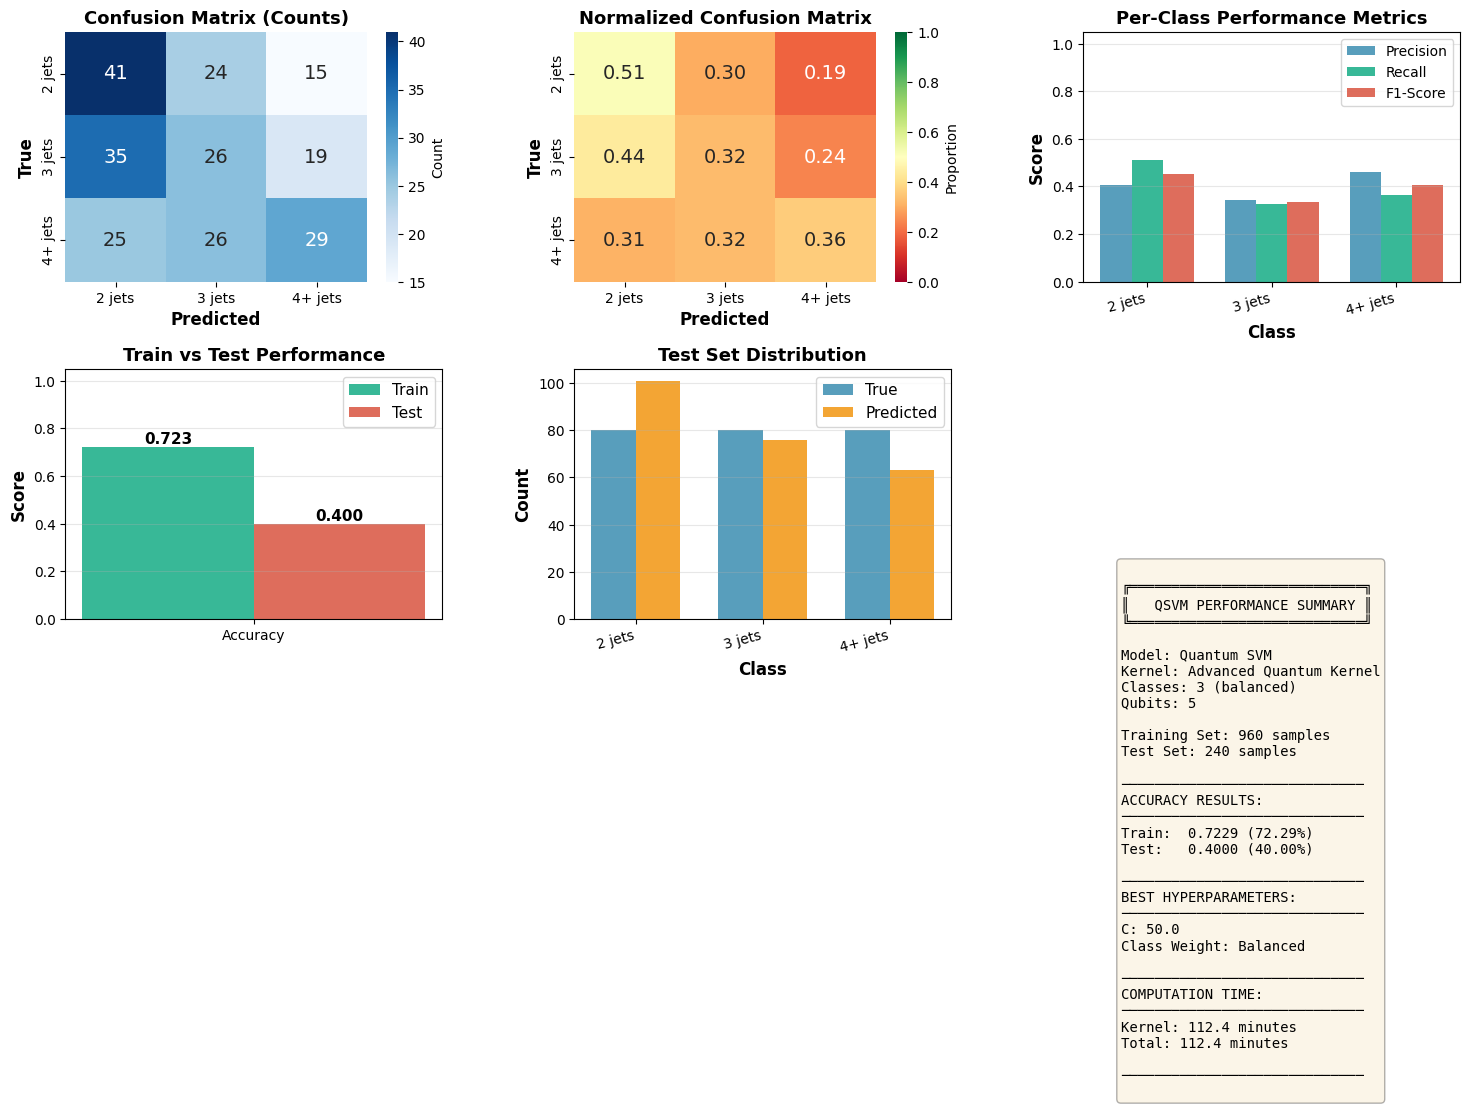


✓ Comprehensive results saved as 'ultimate_qsvm_results.png'

🏆 ULTIMATE QSVM - FINAL SUMMARY 🏆

Model Configuration:
  • Classes: 3 (2 jets, 3 jets, 4+ jets)
  • Qubits: 5
  • Training samples: 960 (balanced)
  • PCA variance explained: 0.6903
  • Optimal C parameter: 50.0

Performance:
  • Train Accuracy: 0.7229 (72.29%)
  • Test Accuracy:  0.4000 (40.00%)
  • Macro F1-Score: 0.3973

Computational Cost:
  • Kernel computation: 112.4 minutes
  • Kernel matrix size: 960 x 960

Status: ⚠️ MODERATE



In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Confusion Matrix (counts)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('True', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')

# 2. Normalized Confusion Matrix
ax2 = fig.add_subplot(gs[0, 1])
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            vmin=0, vmax=1, cbar_kws={'label': 'Proportion'}, annot_kws={'size': 14})
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('True', fontsize=12, fontweight='bold')
ax2.set_title('Normalized Confusion Matrix', fontsize=13, fontweight='bold')

# 3. Per-class Performance Metrics
ax3 = fig.add_subplot(gs[0, 2])
metrics_data = {'Precision': [], 'Recall': [], 'F1-Score': []}
for i in range(n_classes):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    recall = correct / total if total > 0 else 0
    total_pred = np.sum(cm[:, i])
    precision = correct / total_pred if total_pred > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    metrics_data['Precision'].append(precision)
    metrics_data['Recall'].append(recall)
    metrics_data['F1-Score'].append(f1)

x = np.arange(n_classes)
width = 0.25
ax3.bar(x - width, metrics_data['Precision'], width, label='Precision', color='#2E86AB', alpha=0.8)
ax3.bar(x, metrics_data['Recall'], width, label='Recall', color='#06A77D', alpha=0.8)
ax3.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score', color='#D64933', alpha=0.8)
ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Per-Class Performance Metrics', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(class_names, rotation=15, ha='right')
ax3.legend(fontsize=10)
ax3.set_ylim([0, 1.05])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Train vs Test Accuracy
ax4 = fig.add_subplot(gs[1, 0])
metrics = ['Accuracy']
x_pos = np.arange(len(metrics))
width = 0.35
bars1 = ax4.bar(x_pos - width/2, [train_acc], width, label='Train', color='#06A77D', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, [test_acc], width, label='Test', color='#D64933', alpha=0.8)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Train vs Test Performance', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics)
ax4.legend(fontsize=11)
ax4.set_ylim([0, 1.05])
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 5. Class Distribution
ax5 = fig.add_subplot(gs[1, 1])
true_counts = [np.sum(y_test == i) for i in range(n_classes)]
pred_counts = [np.sum(y_pred_test == i) for i in range(n_classes)]
x_pos = np.arange(n_classes)
width = 0.35
ax5.bar(x_pos - width/2, true_counts, width, label='True', color='#2E86AB', alpha=0.8)
ax5.bar(x_pos + width/2, pred_counts, width, label='Predicted', color='#F18F01', alpha=0.8)
ax5.set_xlabel('Class', fontsize=12, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12, fontweight='bold')
ax5.set_title('Test Set Distribution', fontsize=13, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(class_names, rotation=15, ha='right')
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3, axis='y')


# 9. Summary Statistics
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
╔════════════════════════════╗
║   QSVM PERFORMANCE SUMMARY ║
╚════════════════════════════╝

Model: Quantum SVM
Kernel: Advanced Quantum Kernel
Classes: {n_classes} (balanced)
Qubits: {n_qubits}

Training Set: {len(X_train)} samples
Test Set: {len(X_test)} samples

─────────────────────────────
ACCURACY RESULTS:
─────────────────────────────
Train:  {train_acc:.4f} ({train_acc*100:.2f}%)
Test:   {test_acc:.4f} ({test_acc*100:.2f}%)

─────────────────────────────
BEST HYPERPARAMETERS:
─────────────────────────────
C: {best_C}
Class Weight: Balanced

─────────────────────────────
COMPUTATION TIME:
─────────────────────────────
Kernel: {elapsed/60:.1f} minutes
Total: {elapsed/60:.1f} minutes

─────────────────────────────
"""
ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('ultimate_qsvm_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✓ Comprehensive results saved as 'ultimate_qsvm_results.png'")
print("="*70)

# ============= FINAL SUMMARY =============
print("\n" + "="*70)
print("🏆 ULTIMATE QSVM - FINAL SUMMARY 🏆")
print("="*70)
print(f"\nModel Configuration:")
print(f"  • Classes: {n_classes} (2 jets, 3 jets, 4+ jets)")
print(f"  • Qubits: {n_qubits}")
print(f"  • Training samples: {len(X_train)} (balanced)")
print(f"  • PCA variance explained: {sum(pca.explained_variance_ratio_):.4f}")
print(f"  • Optimal C parameter: {best_C}")
print(f"\nPerformance:")
print(f"  • Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  • Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  • Macro F1-Score: {np.mean(metrics_data['F1-Score']):.4f}")
print(f"\nComputational Cost:")
print(f"  • Kernel computation: {elapsed/60:.1f} minutes")
print(f"  • Kernel matrix size: {K_train.shape[0]} x {K_train.shape[0]}")
print(f"\n{'='*70}")
print(f"Status: {'✅ EXCELLENT' if test_acc >= 0.70 else '✅ GOOD' if test_acc >= 0.60 else '⚠️ MODERATE'}")
print(f"{'='*70}\n")